In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline,  GenerationConfig
from accelerate import Accelerator


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-09-10 16:37:58,375] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import numpy as np
import os

In [4]:
# Load the data
path = 'output/alpaca-data-pt-br_10000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240909085602/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

losses

[2.0482419967651366,
 1.934519386291504,
 1.8970189094543457,
 1.8448562622070312,
 1.8081686019897463,
 1.8071518898010255,
 1.7885695457458497,
 1.7635337829589843,
 1.782318878173828,
 1.7404255867004395,
 1.7487271308898926,
 1.7228264808654785,
 1.789687156677246,
 1.8042306900024414,
 1.7767580032348633,
 1.706088161468506,
 1.7569808959960938,
 1.728178310394287,
 1.7111284255981445,
 1.771891975402832,
 1.766444206237793,
 1.7181432723999024,
 1.7482949256896974,
 1.7033050537109375,
 1.737483596801758,
 1.7535115242004395,
 1.664972496032715,
 1.7012478828430175,
 1.7529418945312498,
 1.7266925811767577,
 1.7090694427490234,
 1.672346305847168,
 1.7137904167175293,
 1.709891414642334,
 1.6968982696533204,
 1.713186550140381,
 1.7207624435424804,
 1.7192011833190919,
 1.7048821449279785,
 1.712827777862549,
 1.6788042068481446,
 1.6755254745483399,
 1.7179819107055665,
 1.6997598648071288,
 1.6548652648925781,
 1.7096147537231445,
 1.7542726516723635,
 1.7160103797912596,
 1.67

In [5]:
path = 'output/alpaca-data-pt-br_30000_fedavg_c60s2_i10_b16a1_l512_r8a16_20240910094609/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

losses2

[1.956685733795166,
 1.980478000640869,
 1.8482020378112793,
 1.8315839767456055,
 1.7653930664062498,
 1.8093928337097167,
 1.8366108894348145,
 1.769669246673584,
 1.7685572624206543,
 1.752507209777832,
 1.7761323928833008,
 1.7638651847839355,
 1.751626682281494,
 1.7687915802001952,
 1.783167839050293,
 1.769325923919678,
 1.7619964599609377,
 1.7248931884765626,
 1.796635055541992,
 1.7757110595703125,
 1.7483448028564452,
 1.746025562286377,
 1.7187485694885254,
 1.7212763786315919,
 1.7712292671203613,
 1.7400334358215332,
 1.7609395027160644,
 1.7105083465576172,
 1.7632781982421875,
 1.7519187927246094,
 1.7242606163024903,
 1.7045882225036622,
 1.744755744934082,
 1.694749927520752,
 1.7260581016540528,
 1.6911356925964354,
 1.71193208694458,
 1.7002903938293459,
 1.7109858512878418,
 1.6836666107177733,
 1.7338935852050783,
 1.7425056457519532,
 1.7344080924987793,
 1.7251823425292967,
 1.6954815864562989,
 1.675204563140869,
 1.6969889640808105,
 1.7237079620361326,
 1.748

<Axes: >

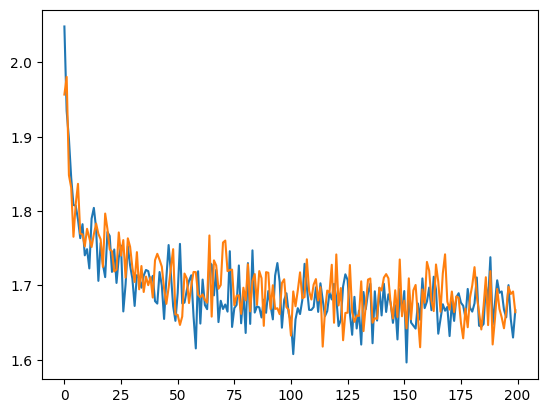

In [6]:
import seaborn as sns

sns.lineplot(x=range(len(losses)), y=losses)
sns.lineplot(x=range(len(losses2)), y=losses2)

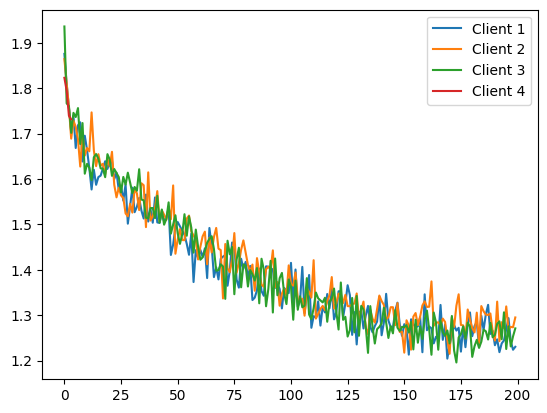

In [7]:
# Load the data
paths = ['output/alpaca-data-pt-br_10000_local1_c20s2_i10_b16a1_l512_r8a16_20240905071418',
         'output/alpaca-data-pt-br_10000_local2_c20s2_i10_b16a1_l512_r8a16_20240905071433',
         'output/alpaca-data-pt-br_10000_local3_c20s2_i10_b16a1_l512_r8a16_20240905071639',
         'output/alpaca-data-pt-br_10000_local4_c20s2_i10_b16a1_l512_r8a16_20240905071708',
         ]

for i, client in enumerate([1, 2, 3, 4]):

    path = paths[i] + '/training_loss.npy'
    data = np.load(path, allow_pickle=True)

    losses = []
    data = data.T
    for r in range(len(data)):
        loss = np.where(data[r] != -1, data[r], np.nan)
        loss = loss[~np.isnan(loss)]
        loss = loss.mean()
        losses.append(loss)

    sns.lineplot(x=range(len(losses)), y=losses, label=f'Client {client}')

In [8]:

import os

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT

#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = 'dominguesm/alpaca-data-pt-br'
PATH = 'output/alpaca-data-pt-br_30000_fedavg_c60s2_i10_b16a1_l512_r8a16_20240910094609'
DEVICE = 'cuda'
NUM_CHECKPOINTS = 20
EVALSET_LEN = 50

path = PATH + f'/checkpoint-60'
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16,
                                                quantization_config = BitsAndBytesConfig(
                                                                        load_in_4bit=True,
                                                                        bnb_4bit_use_double_quant=True,
                                                                        bnb_4bit_quant_type="nf4",
                                                                        bnb_4bit_compute_dtype=torch.bfloat16,
                                                                    ),
                                                device_map={"": Accelerator().local_process_index},)
model = PeftModel.from_pretrained(model, path).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-09-10 17:17:11,425] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.i

In [2]:
dataset = load_dataset(DATASET_NAME, split='train').shuffle(seed=42)
dataset = dataset.select(range(500))
device = 'cuda'

Found cached dataset parquet (/home/gabriel.talasso/.cache/huggingface/datasets/dominguesm___parquet/dominguesm--alpaca-data-pt-br-5efe953862af8eb8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached shuffled indices for dataset at /home/gabriel.talasso/.cache/huggingface/datasets/dominguesm___parquet/dominguesm--alpaca-data-pt-br-5efe953862af8eb8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-b20228def560605b.arrow


In [3]:
def calculate_perplexity(instruction, output):
    # Combine instruction and output
    combined = f"{instruction} [SEP] {output}"
    
    # Tokenize
    encodings = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    
    # Calculate perplexity
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        
    return torch.exp(loss).item()

model.eval()
perplexities = []

for sample in tqdm(dataset):
    instruction = sample["instruction"] + sample["input"]

    perplexity = calculate_perplexity(instruction, sample["output"])
    perplexities.append(perplexity)

# 5. Calculate mean perplexity
mean_perplexity = np.mean(perplexities)
std_perplexity = np.std(perplexities)

print(f"Mean Perplexity: {mean_perplexity:.2f}")
print(f"Standard Deviation of Perplexity: {std_perplexity:.2f}")

# 6. (Optional) Print perplexities for each sample
#for i, (sample, perplexity) in enumerate(zip(dataset, perplexities)):
#    instruction = sample["instruction"] + sample["input"]
#    print(f"Sample {i + 1}:")
#    print(f"Instruction: {instruction}")
#    print(f"Output: {sample['output']}")
#    print(f"Perplexity: {perplexity:.2f}")
#    print("-" * 50)

100%|██████████| 500/500 [01:06<00:00,  7.48it/s]

Mean Perplexity: 60.08
Standard Deviation of Perplexity: 115.68


In [ ]:
#base model
Mean Perplexity: 72.65
Standard Deviation of Perplexity: 137.91


#model with 10 rounds
Mean Perplexity: 69.00
Standard Deviation of Perplexity: 138.36


#model with 50 rounds
Mean Perplexity: 60.29
Standard Deviation of Perplexity: 115.26


#model with 100 rounds
Mean Perplexity: 60.93
Standard Deviation of Perplexity: 115.26


#model with 200 rounds
Mean Perplexity: 61.11
Standard Deviation of Perplexity: 116.74

In [ ]:

#model 2 with with 10 rounds
Mean Perplexity: 67.78
Standard Deviation of Perplexity: 134.27


#model 2 with with 50 rounds
Mean Perplexity: 59.74
Standard Deviation of Perplexity: 115.39

#model 2 with with 100 rounds
Mean Perplexity: 60.36
Standard Deviation of Perplexity: 115.76


#model 2 with with 200 rounds
Mean Perplexity: 60.32
Standard Deviation of Perplexity: 119.07